In [22]:
import os 
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.models import *
from tensorflow.keras.layers import *

from tensorflow.python.keras.utils.generic_utils import get_custom_objects
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"



# Model Shape

In [23]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

def hourglass_network(input_shape, num_classes, num_stacks, num_channels):
    
    input = Input(input_shape)

    start = front_module(input, num_channels)

    head_next_stage = start

    outs = []
    for i in range(num_stacks):
        head_next_stage, head_to_loss = hourglass_module(head_next_stage, num_classes, num_channels, i)
        outs.append(head_to_loss)
    
    x = Flatten()(outs[-1])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation=None, name='Predictions')(x)

    model = Model(inputs=input, outputs=x)
    
    return model

def hourglass_module(bottom, num_classes, num_channels, hgid):

    left_features = left_half_blocks(bottom, hgid, num_channels)

    rf1 = right_half_blocks(left_features, hgid, num_channels)
    
    head_next_stage, head_parts = heads(bottom, rf1, num_classes, hgid, num_channels)

    return head_next_stage, head_parts

def front_module(input, num_channels):
    
    x = Conv2D(64,kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu', name='front_conv_1x1_x1')(
        input)
    x = BatchNormalization()(x)
    x = bottleneck_block(x, int(num_channels // 2), 'front_residual_x1')
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = bottleneck_block(x, int(num_channels // 2), 'front_residual_x2')
    x = bottleneck_block(x, num_channels, 'front_residual_x3')

    return x

def heads(prelayerfeatures, rf1, num_classes, hgid, num_channels):
    
    head = Conv2D(num_channels, kernel_size=(1, 1), activation='relu', padding='same', name=str(hgid) + 'conv_1x1_x1')(
        rf1)
    head = BatchNormalization()(head)

    head_parts = Conv2D(num_classes, kernel_size=(1, 1), activation='linear', padding='same',
                        name=str(hgid) + 'conv_1x1_parts')(head)

    head = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                  name=str(hgid) + 'conv_1x1_x2')(head)
    head_m = Conv2D(num_channels, kernel_size=(1, 1), activation='linear', padding='same',
                    name=str(hgid) + 'conv_1x1_x3')(head_parts)

    head_next_stage = Add()([head, head_m, prelayerfeatures])
    return head_next_stage, head_parts


def bottleneck_block(bottom, num_out_channels, block_name):

    if K.int_shape(bottom)[-1] == num_out_channels:
        skip = bottom
    else:
        skip = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                       name=block_name + 'skip')(bottom)

    x = Conv2D(int(num_out_channels / 2), kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + 'conv_1x1_x1')(bottom)
    x = BatchNormalization()(x)
    x = Conv2D(int(num_out_channels / 2), kernel_size=(3, 3), activation='relu', padding='same',
                name=block_name + 'conv_3x3_x2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_out_channels, kernel_size=(1, 1), activation='relu', padding='same',
                name=block_name + 'conv_1x1_x3')(x)
    x = BatchNormalization()(x)
    x = Add(name=block_name + 'residual')([skip, x])

    return x

def left_half_blocks(bottom, hglayer, num_channels):

    hgname = 'hg' + str(hglayer)

    f1 = bottleneck_block(bottom, num_channels, hgname + 'l1')
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f1)

    f2 = bottleneck_block(x, num_channels, hgname + 'l2')
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f2)

    f4 = bottleneck_block(x, num_channels, hgname + 'l4')
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(f4)

    f8 = bottleneck_block(x, num_channels, hgname + 'l8')

    return (f1, f2, f4, f8)

def left_to_right(left, right, name, num_channels):
    
    xleft = bottleneck_block(left, num_channels, name + 'connect')
    xright = UpSampling2D()(right)
    add = Add()([xleft, xright])
    out = bottleneck_block(add, num_channels, name + 'connect_conv')
    return out

def bottom_layer(lf8, hgid, num_channels):
    
    lf8_connect = bottleneck_block(lf8, num_channels, str(hgid) + "lf8")

    x = bottleneck_block(lf8, num_channels, str(hgid) + "lf8_x1")
    x = bottleneck_block(x, num_channels, str(hgid) + "lf8_x2")
    x = bottleneck_block(x, num_channels, str(hgid) + "lf8_x3")

    rf8 = Add()([x, lf8_connect])

    return rf8

def right_half_blocks(leftfeatures, hglayer, num_channels):  #branch_add
    lf1, lf2, lf4, lf8 = leftfeatures

    rf8 = bottom_layer(lf8, hglayer, num_channels)

    rf4 = left_to_right(lf4, rf8, 'hg' + str(hglayer) + 'rf4', num_channels)

    rf2 = left_to_right(lf2, rf4, 'hg' + str(hglayer) + 'rf2', num_channels)

    rf1 = left_to_right(lf1, rf2, 'hg' + str(hglayer) + 'rf1', num_channels)

    return rf1

# Cosine Schehduler

In [24]:
import tensorflow as tf
import tensorflow.keras.backend as K
import math

class CosineAnnealingWarmup(tf.keras.callbacks.Callback):
    def __init__(self, epochs_per_cycle,iteration, max_lr, min_lr, verbose = 1):
        self.epochs_per_cycle = epochs_per_cycle
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.iteration = iteration;
        self.steps = 0;
        self.learning_rate = max_lr;
        self.epochs = 0; # epoch to search min_lr for each iteration 
        self.warmup_epoch = 10  # warmup epcch
        self.verbose = verbose # log
        self.lrates = list() # for graph
        
        
    def cosine_annealing(self, epoch, epochs_per_cycle, max_lr):
        self.epochs += 1; 
        cos_inner = (math.pi * (self.epochs % epochs_per_cycle)) / (epochs_per_cycle)
        self.learning_rate = max_lr/2 * (math.cos(cos_inner) + 1)
        
        if ((self.epochs % epochs_per_cycle) == (epochs_per_cycle-1)):
            self.steps += 1
            self.max_lr *= 0.8
            self.epochs = 0;
            self.epochs_per_cycle = math.floor(self.epochs_per_cycle*1.2)
            
        return max_lr/2 * (math.cos(cos_inner) + 1)
  
    def warm_up(self, epoch):
        
        self.learning_rate = self.max_lr * epoch / self.warmup_epoch
        
        return self.learning_rate

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs = None):
        if (epoch < self.warmup_epoch):
            # warm up learning rate
            lr = self.warm_up(epoch)
       
        elif(self.steps < self.iteration):
            # calculate learning rate
            lr = self.cosine_annealing(epoch, self.epochs_per_cycle, self.max_lr)
            
        else:
            lr = self.min_lr
        
#         if (self.verbose == 1):
#             print('\nEpoch %05d: CosineAnnealingScheduler setting learng rate to %s.' % (epoch + 1, lr))  

        
        K.set_value(self.model.optimizer.lr, lr)

        self.lrates.append(lr)

In [31]:
cosine_schedule = CosineAnnealingWarmup(epochs_per_cycle=300, iteration=2,max_lr = 1e-3, min_lr = 1e-6)

# for i in range(1, 1000 + 1):
#     cosine_schedule.on_epoch_begin(i)
    
# import matplotlib.pyplot as plt

# plt.plot(cosine_schedule.lrates)
# plt.title('Cosine Annealing_Toy')
# plt.xlabel('epochs'); plt.ylabel('learning_rate')
# plt.grid()
# plt.show()

# Train

In [73]:
# Load Data
image_array = np.load('/home/hackerton/jupyter/Pain_data/image.npy')
label_array = np.load('/home/hackerton/jupyter/Pain_data/label.npy').reshape(-1, 16)

# Normalization
X_train = image_array[:180] / 255
y_train = label_array[:180] / 512

X_valid = image_array[180:240] / 255
y_valid = label_array[180:240] / 512

gpus = tf.config.experimental.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])

with strategy.scope():
    model = hourglass_network(input_shape=(512, 512, 1), num_classes=16, num_stacks=1, num_channels=32)
    model.compile(loss=tf.keras.losses.mean_squared_error , optimizer=tf.keras.optimizers.Adam(lr=0.001 ) , metrics=['mse'])
    model.load_weights('/home/hackerton/jupyter/Pain_data/check/pain_final.h5')
# Call Back
monitor = 'val_loss'

reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=12, min_lr=0.0000001,verbose=1)
earlystopper = EarlyStopping(monitor=monitor, patience=50, verbose=1,restore_best_weights=True)
# model_checkpoint = ModelCheckpoint(filepath = '../result/model_save/landmark_model_1.h5', verbose=1, save_best_only=True)

# callbacks_list = [reduce_lr, model_checkpoint, earlystopper]
callbacks_list = [cosine_schedule, earlystopper]

# Train
history = model.fit(X_train, y_train, batch_size=16, epochs=50, shuffle=True, verbose=1, 
               validation_data=(X_valid, y_valid), callbacks=callbacks_list)


model.save('/home/hackerton/jupyter/Pain_data/check/pain_final.h5')

# Predict

pred = model.predict(X_valid)


# Save Prediction
np.save('/home/hackerton/jupyter/Pain_data/predict.npy', pred)


Train on 180 samples, validate on 60 samples
Epoch 1/50
180/180 [==============================] - 31s 173ms/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 2/50
180/180 [==============================] - 2s 11ms/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0226 - val_mse: 0.0226
Epoch 3/50
180/180 [==============================] - 2s 11ms/sample - loss: 0.0172 - mse: 0.0172 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 4/50
180/180 [==============================] - 2s 11ms/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 5/50
180/180 [==============================] - 2s 11ms/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0133 - val_mse: 0.0133
Epoch 6/50
180/180 [==============================] - 2s 11ms/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 7/50
180/180 [==============================] - 2s 11ms/sample - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 8/

Text(0.5,1,'Training and Validation mse')

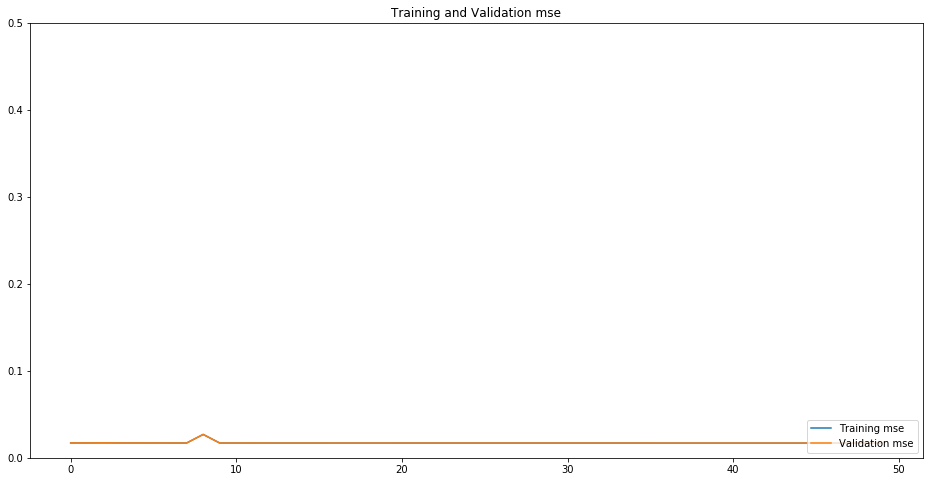

In [74]:
mse = history.history['mse']
val_mse = history.history['mse']

epochs_range = range(len(history.history['mse']))
 
plt.figure(figsize=(16, 8))
plt.plot(epochs_range, mse, label='Training mse')
plt.plot(epochs_range, val_mse, label='Validation mse')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
plt.title('Training and Validation mse')


# Evaluate

In [75]:
# 딥러닝 모델 결과 검증코드
import numpy as np
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score

point_1_distance_error = []
point_2_distance_error = []
point_3_distance_error = []
point_4_distance_error = []
point_5_distance_error = []
point_6_distance_error = []
point_7_distance_error = []
point_8_distance_error = []


original_size_label = np.zeros((60, 8, 2))


predict = np.load('/home/hackerton/jupyter/Pain_data/predict.npy')
label = np.load('/home/hackerton/jupyter/Pain_data/label.npy')[180:]

file_name = np.load('/home/hackerton/jupyter/Pain_data/file_name.npy')[180:]
reduce_ratio = np.load('/home/hackerton/jupyter/Pain_data/reduce_ratio.npy')[180:]
pixel_spacing = np.load('/home/hackerton/jupyter/Pain_data/pixel_spacing.npy')[180:]


original_size_predict = predict * 512
original_size_predict = original_size_predict.reshape(60, 8, 2)


for i in tqdm_notebook(range(predict.shape[0])):

    x_reduce_ratio = reduce_ratio[i][0]
    y_reduce_ratio = reduce_ratio[i][1]

    original_size_label[i][:, 0] = label[i][:, 0] / x_reduce_ratio
    original_size_label[i][:, 1] = label[i][:, 1] / y_reduce_ratio

    original_size_predict[i][:,0] = original_size_predict[i][:, 0] / x_reduce_ratio
    original_size_predict[i][:,1] = original_size_predict[i][:, 1] / y_reduce_ratio

    point_1_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][0] - original_size_predict[i]
                                                                 [:, 0][0])**2 + (original_size_label[i][:, 1][0] - original_size_predict[i][:, 1][0])**2))
    point_2_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][1] - original_size_predict[i]
                                                                 [:, 0][1])**2 + (original_size_label[i][:, 1][1] - original_size_predict[i][:, 1][1])**2))
    point_3_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][2] - original_size_predict[i]
                                                                 [:, 0][2])**2 + (original_size_label[i][:, 1][2] - original_size_predict[i][:, 1][2])**2))
    point_4_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][3] - original_size_predict[i]
                                                                 [:, 0][3])**2 + (original_size_label[i][:, 1][3] - original_size_predict[i][:, 1][3])**2))

    point_5_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][4] - original_size_predict[i]
                                                                 [:, 0][4])**2 + (original_size_label[i][:, 1][4] - original_size_predict[i][:, 1][4])**2))
    point_6_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][5] - original_size_predict[i]
                                                                 [:, 0][5])**2 + (original_size_label[i][:, 1][5] - original_size_predict[i][:, 1][5])**2))
    point_7_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][6] - original_size_predict[i]
                                                                 [:, 0][6])**2 + (original_size_label[i][:, 1][6] - original_size_predict[i][:, 1][6])**2))
    point_8_distance_error.append(pixel_spacing[i][0] * np.sqrt((original_size_label[i][:, 0][7] - original_size_predict[i]
                                                                 [:, 0][7])**2 + (original_size_label[i][:, 1][7] - original_size_predict[i][:, 1][7])**2))


point_1_mean, point_1_std = np.round(
    np.mean(point_1_distance_error), 3), np.round(np.std(point_1_distance_error), 3)
point_2_mean, point_2_std = np.round(
    np.mean(point_2_distance_error), 3), np.round(np.std(point_2_distance_error), 3)
point_3_mean, point_3_std = np.round(
    np.mean(point_3_distance_error), 3), np.round(np.std(point_3_distance_error), 3)
point_4_mean, point_4_std = np.round(
    np.mean(point_4_distance_error), 3), np.round(np.std(point_4_distance_error), 3)


point_5_mean, point_5_std = np.round(
    np.mean(point_5_distance_error), 3), np.round(np.std(point_5_distance_error), 3)
point_6_mean, point_6_std = np.round(
    np.mean(point_6_distance_error), 3), np.round(np.std(point_6_distance_error), 3)
point_7_mean, point_7_std = np.round(
    np.mean(point_7_distance_error), 3), np.round(np.std(point_7_distance_error), 3)
point_8_mean, point_8_std = np.round(
    np.mean(point_8_distance_error), 3), np.round(np.std(point_8_distance_error), 3)


print('Point 1 Distance Error: ', point_1_mean, ' ± ', point_1_std, '     (mm)')
print('Point 2 Distance Error: ', point_2_mean, ' ± ', point_2_std, '     (mm)')
print('Point 3 Distance Error: ', point_3_mean, ' ± ', point_3_std, '     (mm)')
print('Point 4 Distance Error: ', point_4_mean, ' ± ', point_4_std, '     (mm)')

print('Point 5 Distance Error: ', point_5_mean, ' ± ', point_5_std, '     (mm)')
print('Point 6 Distance Error: ', point_6_mean, ' ± ', point_6_std, '     (mm)')
print('Point 7 Distance Error: ', point_7_mean, ' ± ', point_7_std, '     (mm)')
print('Point 8 Distance Error: ', point_8_mean, ' ± ', point_8_std, '     (mm)')


Point 1 Distance Error:  40.774  ±  34.426      (mm)
Point 2 Distance Error:  40.949  ±  34.296      (mm)
Point 3 Distance Error:  52.832  ±  40.492      (mm)
Point 4 Distance Error:  52.989  ±  40.429      (mm)
Point 5 Distance Error:  41.908  ±  28.424      (mm)
Point 6 Distance Error:  41.983  ±  28.509      (mm)
Point 7 Distance Error:  64.41  ±  62.526      (mm)
Point 8 Distance Error:  64.845  ±  62.198      (mm)


In [76]:
# 측정된 거리 검증 코드

import numpy as np
from tqdm import tqdm_notebook

label_line_1 = []
label_line_2 = []
label_line_3 = []
label_line_4 = []

pred_line_1 = []
pred_line_2 = []
pred_line_3 = []
pred_line_4 = []

original_size_label = np.zeros((60, 8, 2))


# predict = np.load('/home/hackerton/jupyter/Pain_data/predict.npy')
# label = np.load('/home/hackerton/jupyter/Pain_data/label.npy')[240:]


# reduce_ratio = np.load('/home/hackerton/jupyter/Pain_data/reduce_ratio.npy')[240:]
# pixel_spacing = np.load('/home/hackerton/jupyter/Pain_data/pixel_spacing.npy')[240:]



original_size_predict = predict * 512
original_size_predict = original_size_predict.reshape(60, 8, 2)


for i in tqdm_notebook(range(predict.shape[0])):

    x_reduce_ratio = reduce_ratio[i][0]
    y_reduce_ratio = reduce_ratio[i][1]

    original_size_label[i][:, 0] = label[i][:, 0] / x_reduce_ratio
    original_size_label[i][:, 1] = label[i][:, 1] / y_reduce_ratio

    original_size_predict[i][:,0] = original_size_predict[i][:, 0] / x_reduce_ratio
    original_size_predict[i][:,1] = original_size_predict[i][:, 1] / y_reduce_ratio

    label_line_1.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_label[i][0][0] -
                                                                original_size_label[i][1][0])**2 + (original_size_label[i][0][1] - original_size_label[i][1][1])**2), 3))
    label_line_2.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_label[i][2][0] -
                                                                original_size_label[i][3][0])**2 + (original_size_label[i][2][1] - original_size_label[i][3][1])**2), 3))
    label_line_3.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_label[i][4][0] -
                                                                original_size_label[i][5][0])**2 + (original_size_label[i][4][1] - original_size_label[i][5][1])**2), 3))
    label_line_4.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_label[i][6][0] -
                                                                original_size_label[i][7][0])**2 + (original_size_label[i][6][1] - original_size_label[i][7][1])**2), 3))

    pred_line_1.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_predict[i][0][0] - original_size_predict[i][1][0])**2 + (
        original_size_predict[i][0][1] - original_size_predict[i][1][1])**2), 3))
    pred_line_2.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_predict[i][2][0] - original_size_predict[i][3][0])**2 + (
        original_size_predict[i][2][1] - original_size_predict[i][3][1])**2), 3))
    pred_line_3.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_predict[i][4][0] - original_size_predict[i][5][0])**2 + (
        original_size_predict[i][4][1] - original_size_predict[i][5][1])**2), 3))
    pred_line_4.append(np.round(pixel_spacing[i][0] * np.sqrt((original_size_predict[i][6][0] - original_size_predict[i][7][0])**2 + (
        original_size_predict[i][6][1] - original_size_predict[i][7][1])**2), 3))

print('Line 1 R2 Score: ',r2_score(label_line_1, pred_line_1))
print('Line 2 R2 Score: ',r2_score(label_line_2, pred_line_2))
print('Line 3 R2 Score: ',r2_score(label_line_3, pred_line_3))
print('Line 4 R2 Score: ',r2_score(label_line_4, pred_line_4))


Line 1 R2 Score:  -4.851438379567778
Line 2 R2 Score:  -2.4432105169579024
Line 3 R2 Score:  -3.110664328217755
Line 4 R2 Score:  -2.2087769563873225


In [77]:
line_1_distance_error_mean, line_1_distance_error_std = np.round(np.mean(np.abs(np.array(
    label_line_1) - np.array(pred_line_1))), 3), np.round(np.std(np.abs(np.array(label_line_1) - np.array(pred_line_1))), 3)
line_2_distance_error_mean, line_2_distance_error_std = np.round(np.mean(np.abs(np.array(
    label_line_2) - np.array(pred_line_2))), 3), np.round(np.std(np.abs(np.array(label_line_2) - np.array(pred_line_2))), 3)
line_3_distance_error_mean, line_3_distance_error_std = np.round(np.mean(np.abs(np.array(
    label_line_3) - np.array(pred_line_3))), 3), np.round(np.std(np.abs(np.array(label_line_3) - np.array(pred_line_3))), 3)
line_4_distance_error_mean, line_4_distance_error_std = np.round(np.mean(np.abs(np.array(
    label_line_4) - np.array(pred_line_4))), 3), np.round(np.std(np.abs(np.array(label_line_4) - np.array(pred_line_4))), 3)


print('Line 1 Distance Error: ', line_1_distance_error_mean,
      ' ± ', line_1_distance_error_std, '     (mm)')
print('Line 2 Distance Error: ', line_2_distance_error_mean,
      ' ± ', line_2_distance_error_std, '     (mm)')
print('Line 3 Distance Error: ', line_3_distance_error_mean,
      ' ± ', line_3_distance_error_std, '     (mm)')
print('Line 4 Distance Error: ', line_4_distance_error_mean,
      ' ± ', line_4_distance_error_std, '     (mm)')

Line 1 Distance Error:  4.091  ±  1.861      (mm)
Line 2 Distance Error:  2.454  ±  1.422      (mm)
Line 3 Distance Error:  3.31  ±  1.868      (mm)
Line 4 Distance Error:  3.101  ±  1.783      (mm)
